In [19]:
from divergence_plotting import *
from basic_plotting import get_target_results, split_on_underscore
from universal_divergence import estimate

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

WDIR = Path().cwd().parent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
_dirs = [
    "WASP-19b",
    "WASP-17b",
    "WASP-12b",
    "HD-189733b",
    "HAT-P-26b",
    # "HAT-P-12b",
    "HAT-P-1b",
    # "WASP-39b",
    # "WASP-121b",
]

# dirs = [WDIR / "data/retrievals" / d for d in _dirs]

dirs = [WDIR / "data/retrievals" / d for d in _dirs]

planets = []
paths = []

for d in dirs:
    # par_names, traces, weights, truths, subsamples, divergences_truth, cross_divergences
    __, path, divs = get_high_weight_subsample(d)

    planets.append(divs)
    paths.append(path)


In [81]:
data = np.array(planets, dtype=object).T
print(data.shape)

(7, 6)


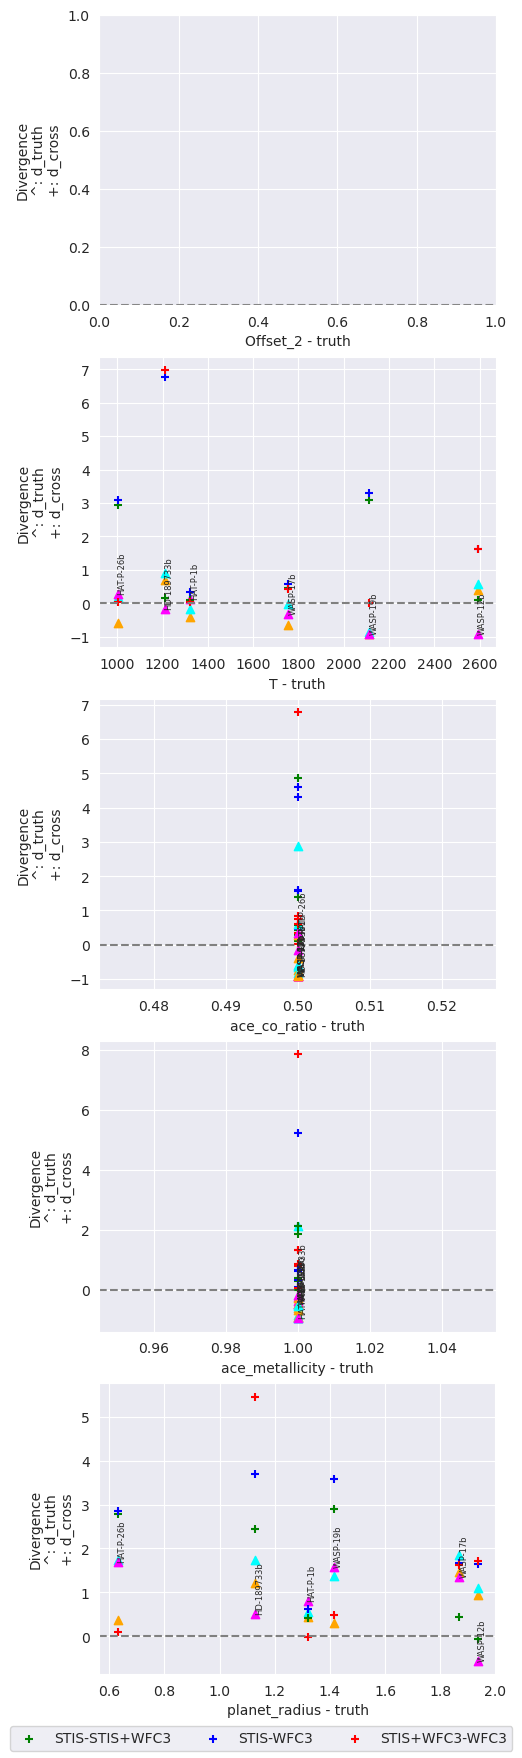

In [82]:
def plot_divergence_par(par_name, data, paths, label_points=False):
    ax = plt.gca()
    ax.axhline(0, ls="dashed", color="gray")

    colors = {
        "STIS-WFC3": "blue",
        "STIS-STIS+WFC3": "green",
        "STIS+WFC3-WFC3": "red",
    }

    colors_inst = {
        "WFC3": "blue",
        "STIS": "green",
        "STIS+WFC3": "red",
    }

    colors_inst = ["orange", "cyan", "magenta", "black"]



    for p in range(data.shape[1]):
        idxs = [np.argwhere(data[0, p][i] == par_name) for i in range(len(data[0, p]))]

        if np.all([len(idx) == 0 for idx in idxs]):
            continue

        cross_divergences = {}
        for i, idx in enumerate(idxs):

            if par_name not in data[3, p][i]:
                continue

            truth = data[3, p][i][par_name]
            divergence_truth = data[5, p][i][par_name]

            for k in data[6, p].keys():

                label = f'{k.replace("instrument(", "").replace(")", "")}'.replace("_", "+")

                cross_divergences[label] = data[6, p][k][par_name]

            label1=[None] * len(idxs)
            if p == data.shape[1] - 1 and label_points:
                label1 = split_on_underscore(paths[i])[2]

            active = np.array(divergence_truth)
            ax.scatter(truth * np.ones_like(active),
                       active,
                       marker="^",
                       c=colors_inst[i],
                       labels=label1)

        labels = [None] * len(cross_divergences.keys())
        if p == data.shape[1] - 1 and label_points:
            labels = [k for k in cross_divergences.keys()]

        for (k, v), label in zip(cross_divergences.items(), labels):
            active = np.array(v)
            ax.scatter(truth * np.ones_like(active),
                       active, marker="+",
                       c=colors[k],
                       label=label,
                       )

        planet_name = Path(paths[p][0]).parent.parent.stem

        try:
            ax.annotate(f"{planet_name}",
                        (truth , divergence_truth),
                        ha="left", va="bottom", rotation=90,
                        fontsize=6,)
        except UnboundLocalError:
            continue



    ax.set_xlabel(f"{par_name} - truth")
    ax.set_ylabel("Divergence\n^: d_truth\n+: d_cross")

    return len(labels) + len(idxs)

def plot_divergence(data, paths):

    all_names = np.unique(np.concatenate(tuple(
        np.array([[data[0, p][i] for i in range(len(data[0, p]))]
         for p in range(len(data[0]))], dtype=object).flatten()
    )).flatten())

    fig, axes = plt.subplots(len(all_names), 1,
                           constrained_layout=True,
                           figsize=(5, len(all_names) * 3.5))

    for i, (ax, par_name) in enumerate(zip(axes, all_names)):
        plt.sca(ax)

        labels = plot_divergence_par(par_name, data, paths, label_points=i==len(axes)-1)

    fig.legend(loc='outside lower center',
          fancybox=True, shadow=False, ncol=len(labels))

    #plt.show()

    # filename = Path(paths[0]).parent.parent / "divergences.png"
    filename = Path(WDIR / "data") / "divergences_observations.png"
    plt.savefig(filename, dpi=300)

plot_divergence(data, paths)

# plot_divergence_par("ace_co_ratio", data)

In [92]:
rng = default_rng()

x = rng.normal(1, size=200).reshape((-1, 1))
y = rng.uniform(low=0, high=2, size=200).reshape((-1, 1))
z = np.ones_like(x)  + rng.uniform(low=-1e-5, high=1e-5, size=200).reshape((-1, 1))

xy = estimate(x, y)
xz = estimate(x, z)
yz = estimate(y, z)

In [93]:
print(xy, xz, yz)

0.6126357929117561 4.635141919029666 4.666289627910192


(3, 200, 1)


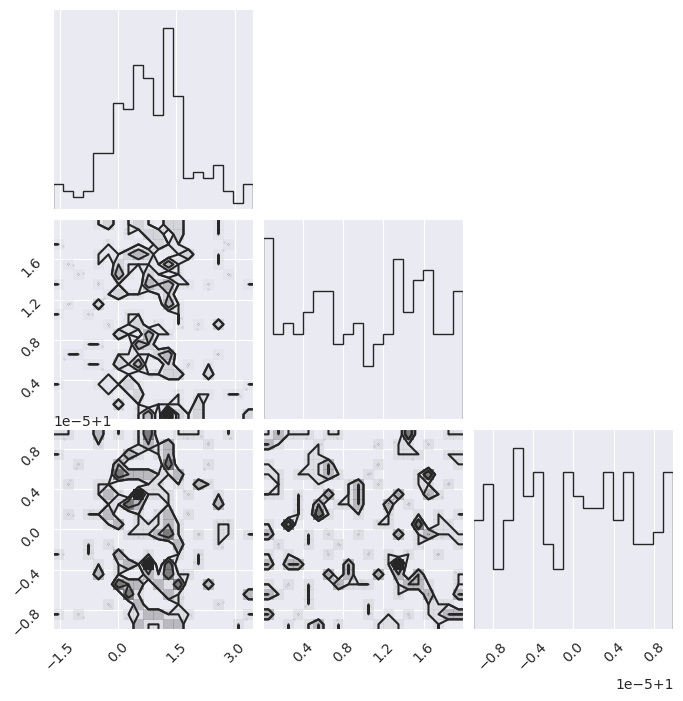

In [95]:
_data = np.array([x, y, z])
print(_data.shape)
corner(_data.T.squeeze())
plt.show()